# Assignment 1 - Steady-State Conduction

Solve each of the following problems and explain your results. For each problem, determine an appropriate number of control volumes through a grid independence study. Determine the number of iterations required for convergence and comment on the result.

## Problem 1 - Linear Heat Conduction

Solve for the one-dimensional temperature distribution in a square bar of mild steel as given below. The properties of mild steel are:

 - $k$ = 60 [W/m$\cdot$K]
 - $\rho$ = 7800 [kg/m$^3$]
 - $c_p$ = 430 [J/kg$\cdot$K]
 
Assume the convection coefficient is zero on the exposed surfaces, and fixed end temperatures of $T_1$ =100 [$^\circ$C] and $T_2$ = 0 [$^\circ$C].

![SquareBar](Figures/1-SquareBar.png)

In [6]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""
    
    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in y-direction [m]
            lz .... total length of domain in z-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv
        
        # Calculate the control volume length
        dx = lx/float(ncv)
        
        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])
        
        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] + 
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])
        
        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)
        
        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)
        
        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
    
    @property
    def xf(self):
        """Face location array"""
        return self._xf
    
    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP
    
    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]
        
    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]
      
    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]
    
    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]
    
    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao
    
    @property
    def vol(self):
        """Cell volume array"""
        return self._vol

In [7]:
class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """
    
    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)
        
    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)
        
    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP
        
    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE
        
    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
        
    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP
    
    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW
    
    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE
    
    @property
    def rP(self):
        """Cell residual"""
        return self._rP

In [8]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

In [9]:
class DirichletBc:
    """Class defining a Dirichlet boundary condition"""
    
    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        return self._value
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 0
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

In [10]:
class NeumannBc:
    """Class defining a Neumann boundary condition"""
    
    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 1
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

In [11]:
class DiffusionModel:
    """Class defining a diffusion model"""
    
    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc
        
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
        
        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE
        
        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE
        
        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()
        
        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0
        
        # Calculate the net flux from each cell
        flux = flux_e - flux_w
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        
        # Return the modified coefficient array
        return coeffs
    

In [12]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)

In [13]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 100, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 29.99999999999997; Avg. Resid. = 2.9999999999999973
Iteration = 1; Max. Resid. = 4.218847493575595e-15; Avg. Resid. = 2.1316282072803005e-15


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()


## Problem 2 - External Convection

Consider the same geometry and properties as in problem 1, except use $h$ = 12 [W/m$^2\cdot$K] for the exposed surfaces of the bar, and end temperatures of $T_1$ = $T_2$ = 100 [$^\circ$C].  Assume the surrounding air to be at $T_{\infty}$ = 25 [$^\circ$C]. Obtain the solution for this problem and compare your solution to the analytical solution.


In [15]:
class SurfaceConvectionModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)
        
        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [16]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 25

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 100, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 100, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 0.18000000000000002; Avg. Resid. = 0.18
Iteration = 1; Max. Resid. = 2.525757381022231e-15; Avg. Resid. = 1.2823075934420559e-15


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

## Problem 3 - Internal Heat Generation

A plane wall $L$ = 0.1 [m] thick with a thermal conductivity of $k$ = 26 [W/m$\cdot$K] is exposed to an environment at an ambient temperature of 50 [$^\circ$C] on one side and an environment of 40 [$^\circ$C] on the other side. The convection coefficient at the exposed surfaces is estimated to be $h$ = 280 [W/m$^2\cdot$K]. If heat is generated uniformly within the wall at a rate 50,000 [W/m$^3$], determine the surface temperatures of the walls, and the location and value of the maximum temperature inside the wall. Compare your result to the analytical result, which can be obtained from a heat transfer textbook.

In [18]:
class InternalHeatModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        #source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)
        source = -50000*self._grid.vol
        
        # Calculate the linearization coefficients
        #coeffP = self._ho*self._grid.Ao
        coeffP = 0
           
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [19]:
class RobinBc:
    """Class defining a Robin boundary condition"""
    
    def __init__(self, phi, grid, value, loc, ho, k):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            value ... environment temperature 
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc
        self._ho = ho
        self._k = k
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            #return self._phi[1] - self._gradient*self._grid.dx_WP[0]
            return (self._phi[1]+self._grid.dx_WP[0]*self._ho/self._k *self._value) / (1+self._grid.dx_WP[0]*self._ho / self._k) 
        elif self._loc is BoundaryLocation.EAST:
            #return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
            return (self._phi[-2]+self._grid.dx_PE[-1]*self._ho/self._k *self._value) / (1+self._grid.dx_PE[-1]*self._ho / self._k) 
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return 1 / (1 + self._grid.dx_WP[0] * self._ho / self._k) 
        elif self._loc is BoundaryLocation.EAST:
            return 1 / (1 + self._grid.dx_PE[-1] * self._ho / self._k) 
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1]+self._grid.dx_WP[0]*self._ho/self._k *self._value) / (1+self._grid.dx_WP[0]*self._ho / self._k)
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = (self._phi[-2]+self._grid.dx_PE[-1]*self._ho/self._k *self._value) / (1+self._grid.dx_PE[-1]*self._ho/self._k)
        else:
            raise ValueError("Unknown boundary location")

In [20]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 26

# Define convection parameters
ho = 280
To = 45

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 50

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = RobinBc(T, grid, 50, BoundaryLocation.WEST, ho, k)
east_bc = RobinBc(T, grid, 40, BoundaryLocation.EAST, ho, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = InternalHeatModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 2156.9343065693665; Avg. Resid. = 665.6934306569367
Iteration = 1; Max. Resid. = 2.148681232938543e-11; Avg. Resid. = 9.15179043659009e-12


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

print('the surface temperatures are %.4f,%.4f' % (T[0],T[-1]))
print('The maximum temperature is %.4f' % max(T))


the surface temperatures are 55.6786,52.1786
The maximum temperature is 56.6651


## Problem 4 - Radiation 

Solve the following problem using the square bar geometry given in question 1 with the same ambient temperature. Assume that the convection coefficient is $h$ = 0 [W/m$^2\cdot$K], the emmisivity is $\epsilon$ = 1.0, the end temperatures are $T_1$ = 400 [K] and $T_2$ = 0 [K]. Try solving this problem using the following linearizations of the radiation source term:

- Apply $q_o^{\prime\prime} = \epsilon \sigma (T^4 - T_\infty^4)$ into the residual and do not include any contribution from this term into the Jacobian matrix. This is an explicit implementation of the source term.
- Apply $q_o^{\prime\prime} = \epsilon \sigma (T^4 - T_\infty^4)$ into the residual and include the linearizaton $\partial q_o^{\prime\prime}/\partial T$ into the Jacobian matrix. This is an implicit implementation of the source term.

Solve using each linearization assuming the material is:

- Steel, for which: $k$ = 60 [W/m$\cdot$K], $c_p$ = 430 [J/kg$\cdot$K]
- Wood, for which: $k$ = 0.1 [W/m$\cdot$K], $c_p$ = 1.3 [J/kg$\cdot$K]

Explain any differences that you observe.

## Explict

In [26]:
class SurfaceConvectionModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, ho, To, eo, so):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To
        self._eo = eo
        self._so = so
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        #source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)
        source = self._eo*self._so*self._grid.Ao*(self._T[1:-1]**4 - self._To**4)
        
        # Calculate the linearization coefficients
        #coeffP = self._ho*self._grid.Ao
        #coeffP = self._eo*self._so*self._grid.Ao
        
        # Add to coefficient arrays
        #coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

## Steel

In [27]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 0
To = 0

#Define radiation parameters
eo = 1
so = 5.67*10**(-8)

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To, eo, so)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))

    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {};".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 89.998866; Avg. Resid. = 12.000907199999997;
Iteration = 1; Max. Resid. = 0.23527338392438296; Avg. Resid. = 0.05683070101789213;
Iteration = 2; Max. Resid. = 0.00553633773331097; Avg. Resid. = 0.0019417775449173176;
Iteration = 3; Max. Resid. = 0.0002139152824981172; Avg. Resid. = 7.731239275263076e-05;
Iteration = 4; Max. Resid. = 8.680238673564045e-06; Avg. Resid. = 3.17781057282176e-06;
Iteration = 5; Max. Resid. = 3.577092851647645e-07; Avg. Resid. = 1.3142804024694331e-07;


In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

## Wood

In [29]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 0.1

# Define convection parameters
ho = 0
To = 0

#Define radiation parameters
eo = 1
so = 5.67*10**(-8)

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To, eo, so)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))

    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {};".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 0.148866; Avg. Resid. = 0.020907199999999994;
Iteration = 1; Max. Resid. = 0.20833373157946325; Avg. Resid. = 0.03930659959452931;
Iteration = 2; Max. Resid. = 14.024067693815464; Avg. Resid. = 4.608273820264898;
Iteration = 3; Max. Resid. = 115745994266.03616; Avg. Resid. = 38683820589.54741;
Iteration = 4; Max. Resid. = 8.650485072891294e+50; Avg. Resid. = 2.8316100809410076e+50;
Iteration = 5; Max. Resid. = 2.9111384167180394e+210; Avg. Resid. = 9.242764179794295e+209;
Iteration = 6; Max. Resid. = inf; Avg. Resid. = inf;
Iteration = 7; Max. Resid. = nan; Avg. Resid. = nan;
Iteration = 8; Max. Resid. = nan; Avg. Resid. = nan;
Iteration = 9; Max. Resid. = nan; Avg. Resid. = nan;
Iteration = 10; Max. Resid. = nan; Avg. Resid. = nan;
Iteration = 11; Max. Resid. = nan; Avg. Resid. = nan;
Iteration = 12; Max. Resid. = nan; Avg. Resid. = nan;
Iteration = 13; Max. Resid. = nan; Avg. Resid. = nan;
Iteration = 14; Max. Resid. = nan; Avg. Resid. = nan;
Iteration = 

C:\Users\zsun82\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in power
C:\Users\zsun82\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


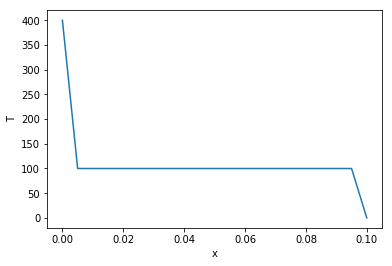

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
#plt.legend()
plt.show()

## Implicit


In [40]:
class SurfaceConvectionModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, ho, To, eo, so):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To
        self._eo = eo
        self._so = so
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        #source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)
        source = self._eo*self._so*self._grid.Ao*(self._T[1:-1]**4 - self._To**4)
        
        # Calculate the linearization coefficients
        #coeffP = self._ho*self._grid.Ao
        coeffP = self._eo*self._so*self._grid.Ao*4*self._T[1:-1]**3
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [41]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 0
To = 0

#Define radiation parameters
eo = 1
so = 5.67*10**(-8)

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To, eo, so)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))

    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {};".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 89.998866; Avg. Resid. = 12.000907199999997;
Iteration = 1; Max. Resid. = 0.2222676354001864; Avg. Resid. = 0.05168862655480122;
Iteration = 2; Max. Resid. = 6.150577484582975e-05; Avg. Resid. = 2.2573609564649667e-05;
Iteration = 3; Max. Resid. = 2.389503872546328e-11; Avg. Resid. = 8.643614023936553e-12;


In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

## Wood

In [42]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 0.1

# Define convection parameters
ho = 0
To = 0

#Define radiation parameters
eo = 1
so = 5.67*10**(-8)

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To, eo, so)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))

    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {};".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 0.148866; Avg. Resid. = 0.020907199999999994;
Iteration = 1; Max. Resid. = 0.12581868811680338; Avg. Resid. = 0.017189250264657625;
Iteration = 2; Max. Resid. = 0.021774146912979214; Avg. Resid. = 0.003267868615178456;
Iteration = 3; Max. Resid. = 0.001197284804443581; Avg. Resid. = 0.00024848558262219377;
Iteration = 4; Max. Resid. = 9.605467454426933e-06; Avg. Resid. = 2.556399304943294e-06;
Iteration = 5; Max. Resid. = 1.521709702689833e-09; Avg. Resid. = 4.892586040762385e-10;


In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

By explicit method, the heat radiation flux is only implemented in source term of the residual, for a large k, the diffusion term dominate the convergence, so we can get a solution for steel by explicit method. For a samller k, the convection and the radiation in the source term take over the conduction, without changing the linearization coefficients in the Jocbian matrix, the residual of the source term accumulates to diverge, that's why we can't get a solution for wood by explicit method. By implicit method, we include the linearization coefficients in the Jocbian matrix, the residual calculated by the source term after every iteration will be modified by the linearization coefficients before returning to the next iteration, so that we can get a converged solution no matter how much the k is. Also, with the help of the implicit method, the number of iterations for the calculation reduces compared to the explicit method, I guess that is because the linearization coefficient reduces the residual.  